Why is Otani's deal cotract deversed $700M/10Y?
---
Data can tell the truth.

[src](https://towardsdatascience.com/comparing-outlier-detection-methods-956f4b097061)

Data Source
---
1. batting_stats from [`FanGraphs`](Fangraphs.com), for well-formated players' names;
2. batting_stats_bref from [`Baseball Reference`](Baseball-Reference.com) for well-formated team name and information about list of traded players.

In [2]:
from pybaseball import (cache, batting_stats_bref, batting_stats, 
                        playerid_reverse_lookup)
import pandas as pd

cache.enable()  # avoid unnecessary requests when re-running

MIN_PLATE_APPEARANCES = 200

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# For readability and reasonable default sort order
df_bref = batting_stats_bref(2023).query(f"PA >= {MIN_PLATE_APPEARANCES}"
                                        ).rename(columns={"Lev":"League","Tm":"Team"})
df_bref.tail(2)

,Name,Age,#days,League,Team,G,PA,AB,R,H,...,SH,SF,GDP,SB,CS,BA,OBP,SLG,OPS,mlbID
680,Christian Yelich,31,171,Maj-NL,Milwaukee,146,642,558,108,157,...,0,1,15,29,3,0.281,0.374,0.450,0.824,592885
682,Masataka Yoshida,29,174,Maj-AL,Boston,140,580,537,71,155,...,0,2,20,8,0,0.289,0.338,0.445,0.783,807799


In [42]:
# Replace "Maj-" in the "League" column and convert "AL,NL" to "NL/AL"
df_bref["League"] = \
  df_bref["League"].str.replace("Maj-","").replace("AL,NL","NL/AL"
                                                  ).astype('category')
# Retrieve batting stats for the 2023 season with the specified qualifying plate appearances
df_fg = batting_stats(2023, qual=MIN_PLATE_APPEARANCES)

# Create a mapping between MLB IDs and FanGraphs IDs
key_mapping = playerid_reverse_lookup(df_bref["mlbID"].tolist(), key_type='mlbam')\
              [["key_mlbam", "key_fangraphs"]]
key_mapping.columns = ["mlbID", "IDfg"]

In [44]:
df_fg.tail(2)

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,maxEV,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR
347,14691,2023,Harold Castro,COL,29,99,258,270,65,51,...,106.1,56,0.287,195,0.142,0.292,0.242,0.339,0.263,-0.9
235,10815,2023,Jurickson Profar,- - -,30,125,459,521,111,73,...,108.8,119,0.317,375,0.151,0.236,0.247,0.349,0.306,-0.9


In [43]:
df_bref.tail(2)

,Name,Age,#days,League,Team,G,PA,AB,R,H,...,SH,SF,GDP,SB,CS,BA,OBP,SLG,OPS,mlbID
680,Christian Yelich,31,171,NL,Milwaukee,146,642,558,108,157,...,0,1,15,29,3,0.281,0.374,0.450,0.824,592885
682,Masataka Yoshida,29,174,AL,Boston,140,580,537,71,155,...,0,2,20,8,0,0.289,0.338,0.445,0.783,807799


In [50]:
key_mapping.tail(2)

,mlbID,IDfg
361,677551,23667
362,680977,24679


In [51]:
df = (
    df_fg.drop(columns="Team")
    .merge(key_mapping, how="inner", left_on="IDfg", right_on="IDfg")
    .merge(df_bref[["mlbID", "League", "Team"]], how="inner", on="mlbID")
    .sort_values(["League", "Team", "Name"])
)

- line 3: Performs an inner join between df_fg and key_mapping DataFrame on the "IDfg" column;
- line 4: Performs another inner join between the result of the previous merge and the df_bref DataFrame, selecting only the "mlbID", "League", and "Team" columns from df_bref. The merge is performed on the "mlbID" column.
- line 5: Sorts the resulting DataFrame by the "League", "Team", and "Name" columns in ascending order.

Using `OBP` and `SLP` to analyze batter performance from 2023’s Major Leage Baseball (MLB) season:

- On-base percentage (`OBP`), the rate at which a batter reaches base (by hitting, walking, or getting hit by pitch) per plate appearance
- Slugging (`SLG`), the average number of total bases per at bat

In [52]:
# general statistics about OBP and SLG
df[["OBP","SLG"]].describe().round(3)

,OBP,SLG
count,362.000,362.000
mean,0.320,0.415
std,0.034,0.068
min,0.234,0.227
25%,0.300,0.367
50%,0.318,0.414
75%,0.340,0.460
max,0.416,0.654


In [10]:
# claculate the covariance matirix; here means the corelation is moderated
df[['OBP','SLG']].corr().round(3)

,OBP,SLG
OBP,1.00,0.63
SLG,0.63,1.00


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

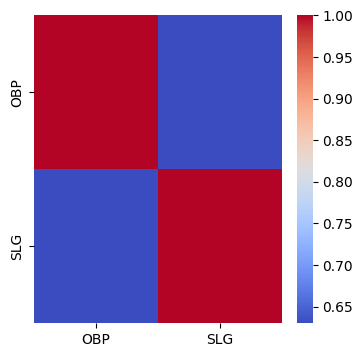

In [20]:
# visualize the corelation 
plt.figure(figsize=(4,4))
sns.heatmap(df[['OBP','SLG']].corr(),cmap="coolwarm");

1. Scatterplot of the players, colored by National League (NL) vs American League (AL)
2. Bivariate kernel density estimator (KDE) plot of the players, which smoothes the scatterplot with a Gaussian kernel to estimate density
3. Marginal KDE plots of each metric

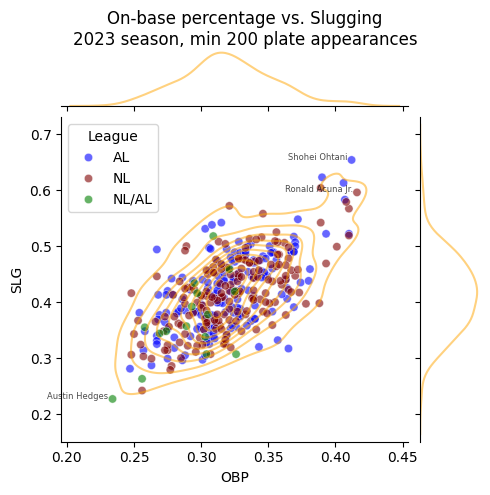

In [23]:
import seaborn as sns
# JointGrid object with the specified data, x-axis, and y-axis columns, and a height of 5.
g = sns.JointGrid(data=df, x="OBP", y="SLG", height=5)
# scatter plot in the joint area, colored by the "League" column with the specified palette, and an opacity of 0.6.
g = g.plot_joint(sns.scatterplot, data=df, hue="League", palette={"AL":"blue", "NL":"maroon", "NL/AL":"green"}, alpha=0.6)
# make title
g.fig.suptitle(f"On-base percentage vs. Slugging\n2023 season, min {MIN_PLATE_APPEARANCES} plate appearances")
# adjusts the spacing between the subplots and the figure title.
g.figure.subplots_adjust(top=0.9)
# plots a 2D kernel density estimation in the joint area.
sns.kdeplot(x=df["OBP"], color="orange", ax=g.ax_marg_x, alpha=0.5)
sns.kdeplot(y=df["SLG"], color="orange", ax=g.ax_marg_y, alpha=0.5)
sns.kdeplot(data=df, x="OBP", y="SLG", ax=g.ax_joint, color="orange", alpha=0.5)
# frame to include only rows with minimum or maximum values of "OBP" or "OPS" 
df_extremes = df[df["OBP"].isin([df["OBP"].min(), df["OBP"].max()]) | df["OPS"].isin([df["OPS"].min(), df["OPS"].max()])]

# display the player's name on the joint plot for those extreme values.
for _, row in df_extremes.iterrows():
    g.ax_joint.annotate(row["Name"], (row["OBP"], row["SLG"]), size=6, xycoords='data', xytext=(-3, 0), textcoords='offset points', ha="right", alpha=0.7)

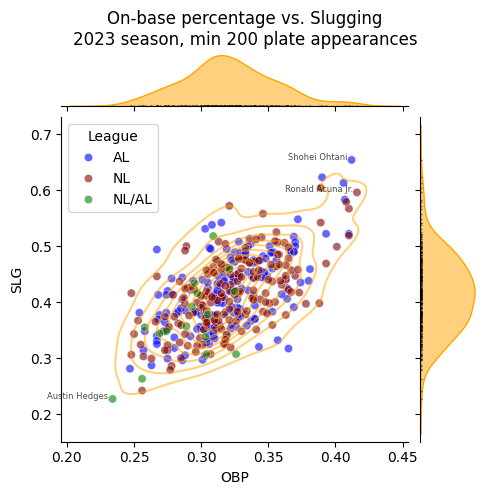

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.JointGrid(data=df, x="OBP", y="SLG", height=5)
g = g.plot_joint(sns.scatterplot, data=df, hue="League", palette={"AL":"blue", "NL":"maroon", "NL/AL":"green"}, alpha=0.6)
g.fig.suptitle(f"On-base percentage vs. Slugging\n2023 season, min {MIN_PLATE_APPEARANCES} plate appearances")
g.figure.subplots_adjust(top=0.9)

# Plot colorful level lines
g = g.plot_marginals(sns.kdeplot, color="orange", alpha=0.5, shade=True)
g = g.plot_marginals(sns.rugplot, color="black", alpha=0.5)

# Plot 2D kernel density estimation
sns.kdeplot(data=df, x="OBP", y="SLG", ax=g.ax_joint, color="orange", alpha=0.5)


df_extremes = df[df["OBP"].isin([df["OBP"].min(), df["OBP"].max()]) | df["OPS"].isin([df["OPS"].min(), df["OPS"].max()])]
for _, row in df_extremes.iterrows():
    g.ax_joint.annotate(row["Name"], (row["OBP"], row["SLG"]), size=6, xycoords='data', xytext=(-3, 0), textcoords='offset points', ha="right", alpha=0.7)

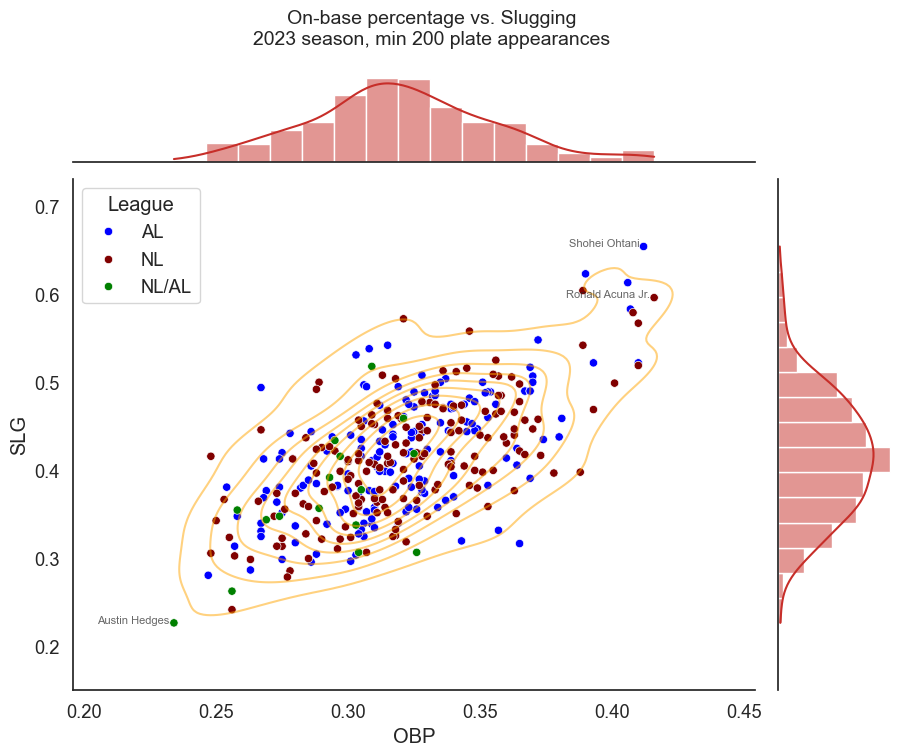

In [77]:

sns.set(style="white", font_scale=1.2)

g = sns.JointGrid(data=df, x='OBP', y='SLG')
g = g.plot_joint(sns.scatterplot, data=df, hue="League", palette={"AL": "blue", "NL": "maroon", "NL/AL": "green"})
# make histogram on X-Y axes
g = g.plot_marginals(sns.histplot, bins=15, kde=True, color='#c72e29')

# Plot 2D kernel density estimation
sns.kdeplot(data=df, x="OBP", y="SLG", ax=g.ax_joint, color="orange", alpha=0.5)

# Add title
g.fig.suptitle(f"On-base percentage vs. Slugging\n2023 season, min {MIN_PLATE_APPEARANCES} plate appearances", fontsize=14)
g.figure.subplots_adjust(top=0.9)
df_extremes = df[(df["OBP"].isin([df["OBP"].min(), df["OBP"].max()])) | (df["OPS"].isin([df["OPS"].min(), df["OPS"].max()]))]

for _, row in df_extremes.iterrows():
    g.ax_joint.annotate(row["Name"], (row["OBP"], row["SLG"]), size=8, \
                        xycoords='data', xytext=(-3, 0), textcoords='offset points', ha="right", alpha=0.7)
    g.fig.set_size_inches(10,8) 

In [78]:
import numpy as np

X = df[["OBP","SLG"]].to_numpy()

GRID_RESOLUTION = 200

disp_x_range, disp_y_range = ( (.6*X[:,i].min(), 1.2*X[:,i].max()) 
                               for i in [0,1]
                             )
xx, yy = np.meshgrid(np.linspace(*disp_x_range, GRID_RESOLUTION), 
                     np.linspace(*disp_y_range, GRID_RESOLUTION)
                    )
grid_shape = xx.shape
grid_unstacked = np.c_[xx.ravel(), yy.ravel()]

Outlier Detection
---
1. Elliptic Envelope, for low dimesional data, each feature data were Gaussian distributed, i.e. normal distributed; 
2. local Outlier Factor,  Observations with much lower density than their neighbors are considered outliers;
3. SVM, typycal algorithm in Machine Learning, ignored here.
4. Isolation Forest, tree-based algorithm, outliers are more quickly isolated by random splits than inliers.

1. `EllipticEnvelope` is a convenient and effective method for outlier detection when the data is expected to follow a multivariate Gaussian distribution, and it provides a way to model the data using an elliptic envelope to identify outliers.



In [79]:
from sklearn.covariance import EllipticEnvelope

ell = EllipticEnvelope(random_state=42).fit(X)
#  calculate the outlier scores for each data point in X
df["outlier_score_ell"] = ell.decision_function(X)
# calculates the outlier scores for a grid of points using the fitted EllipticEnvelope model
Z_ell = ell.decision_function(grid_unstacked).reshape(grid_shape)

In [80]:
K = int(np.sqrt(X.shape[0]))

print(f"Using K={K} nearest neighbors.")

Using K=19 nearest neighbors.


In [81]:
# additional 
from scipy.spatial.distance import pdist, squareform

# If we didn't have the elliptical envelope already,
# we could calculate robust covariance:
#   from sklearn.covariance import MinCovDet
#   robust_cov = MinCovDet().fit(X).covariance_
# But we can just re-use it from elliptical envelope:
robust_cov = ell.covariance_

print(f"Robust covariance matrix:\n{np.round(robust_cov,5)}\n")

inv_robust_cov = np.linalg.inv(robust_cov)

D_mahal = squareform(pdist(X, 'mahalanobis', VI=inv_robust_cov))

print(f"Mahalanobis distance matrix of size {D_mahal.shape}, "
      f"e.g.:\n{np.round(D_mahal[:5,:5],3)}...\n...\n")

Robust covariance matrix:
[[0.00077 0.00095]
 [0.00095 0.00366]]

Mahalanobis distance matrix of size (362, 362), e.g.:
[[0.    2.86  1.278 0.964 0.331]
 [2.86  0.    2.63  2.245 2.813]
 [1.278 2.63  0.    0.561 0.956]
 [0.964 2.245 0.561 0.    0.723]
 [0.331 2.813 0.956 0.723 0.   ]]...
...



`LocalOutlierFactor`

- n_neighbors=K: Specifies the number of neighbors to consider for each data point.
- metric="precomputed": Indicates that the distance matrix is precomputed and provided as input.
- novelty=True: Enables the use of the LocalOutlierFactor for novelty detection.
- D_mahal is likely a precomputed distance matrix based on the Mahalanobis distance.
- `negative_outlier_factor_` contains the negative outlier factor scores for each data point, where higher values indicate more likely outliers.

In [82]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=K, metric="precomputed", novelty=True
                        ).fit(D_mahal)

df["outlier_score_lof"] = lof.negative_outlier_factor_

- compute the Mahalanobis distance between grid_unstacked (a flattened version of a grid of points) and the original data X
- D_mahal_grid is computed as the Mahalanobis distance between grid_unstacked (a flattened version of a grid of points) and the original data X, then reshape.

`Mahalanobis` distance:

$$D_M(x) = \sqrt{ (X - \mu)^T \Sigma^{-1} (X- \mu) } $$
where 
- $X=(x^1,x^2,\cdots,x^n)$, $\mu=EX$.
- $\Sigma$ is the covariance matrix of the distribution

In [83]:
from scipy.spatial.distance import cdist

D_mahal_grid = cdist(XA=grid_unstacked, XB=X, 
                     metric='mahalanobis', VI=inv_robust_cov
                    )
Z_lof = lof.decision_function(D_mahal_grid).reshape(grid_shape)

In [84]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM

suv = make_pipeline(
            RobustScaler(),
            Nystroem(random_state=17),
            SGDOneClassSVM(random_state=17)
).fit(X)

df["outlier_score_svm"] = suv.decision_function(X)

Z_svm = suv.decision_function(grid_unstacked).reshape(grid_shape)

In [85]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(random_state=17).fit(X)

df["outlier_score_iso"] = iso.score_samples(X)

Z_iso = iso.decision_function(grid_unstacked).reshape(grid_shape)

In [33]:
from adjustText import adjust_text
from sklearn.preprocessing import QuantileTransformer

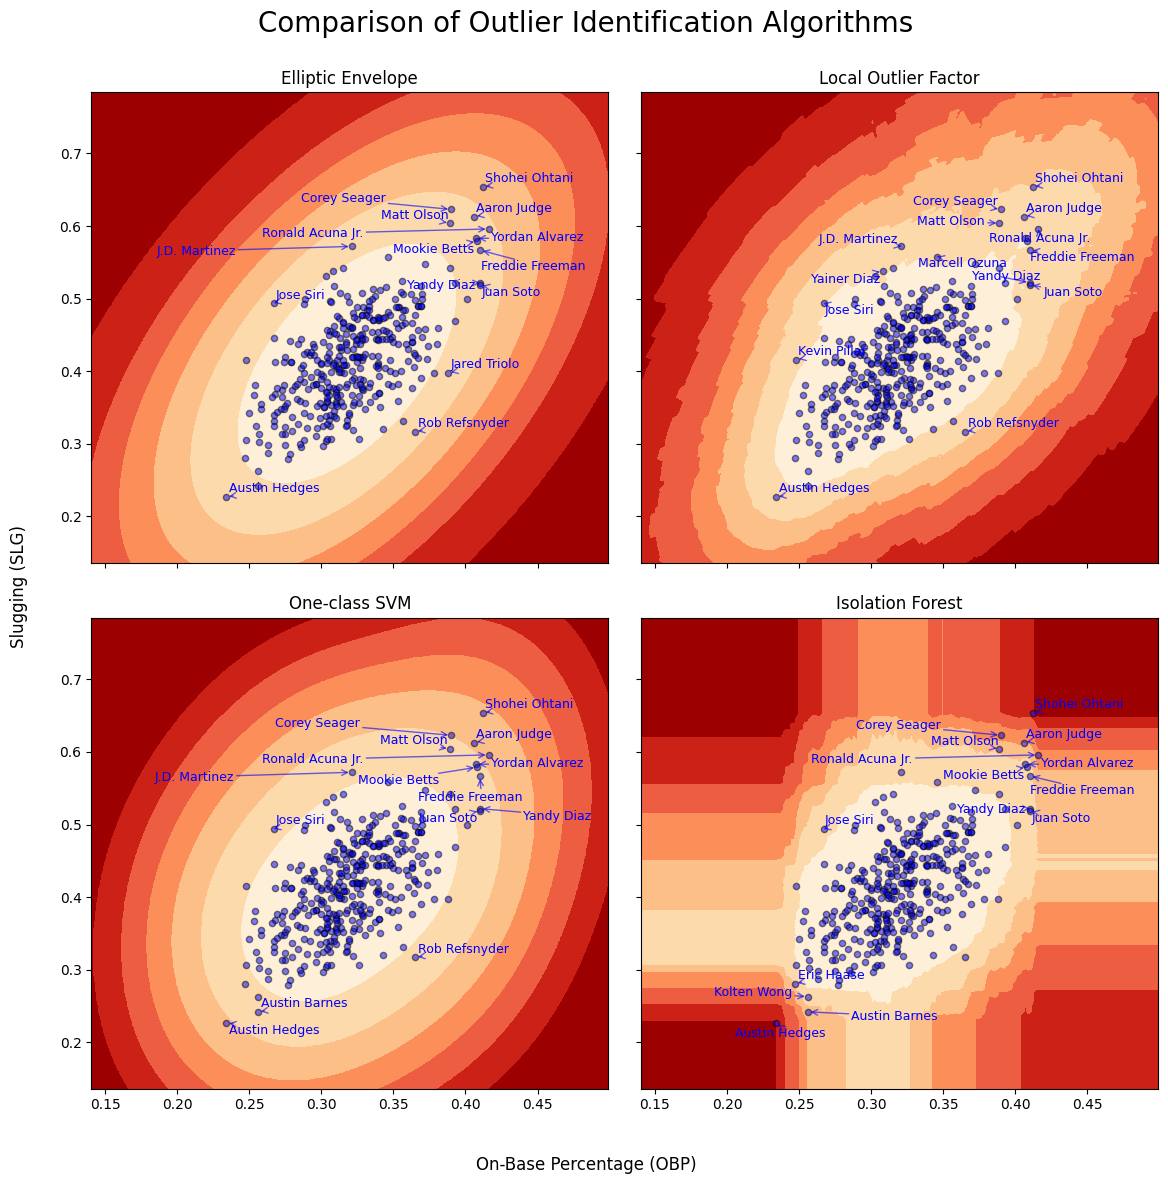

Counting down to the greatest outlier...

            Name  AB  PA   H  2B  3B  HR  BB  HBP  SO   OBP  Pctl_OBP   SLG  Pctl_SLG  Rank_ELL  Rank_ISO  Rank_LOF  Rank_SVM
   Austin Barnes 178 200  32   5   0   2  17    2  43 0.256       2.6 0.242       0.6        19         7        25        12
   J.D. Martinez 432 479 117  27   2  33  34    2 149 0.321      52.8 0.572      98.1        15        18         5        15
      Yandy Diaz 525 600 173  35   0  22  65    8  94 0.410      99.2 0.522      95.4        13        15        13        10
       Jose Siri 338 364  75  13   2  25  20    2 130 0.267       5.5 0.494      88.4         8        14        15        13
       Juan Soto 568 708 156  32   1  35 132    2 129 0.410      99.2 0.519      95.0        12        13        11        11
    Mookie Betts 584 693 179  40   1  39  96    8 107 0.408      98.6 0.579      98.3         7        10        20         7
   Rob Refsnyder 202 243  50   9   1   1  33    5  47 0.365      90.5 0.317 

In [34]:
N_QUANTILES = 8 # This many color breaks per chart
N_CALLOUTS=15  # Label this many top outliers per chart

fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

fig.suptitle("Comparison of Outlier Identification Algorithms",size=20)
fig.supxlabel("On-Base Percentage (OBP)")
fig.supylabel("Slugging (SLG)")

ax_ell = axs[0,0]
ax_lof = axs[0,1]
ax_svm = axs[1,0]
ax_iso = axs[1,1]

model_abbrs = ["ell","iso","lof","svm"]

qt = QuantileTransformer(n_quantiles=N_QUANTILES)

for ax, nm, abbr, zz in zip( [ax_ell,ax_iso,ax_lof,ax_svm], 
                            ["Elliptic Envelope","Isolation Forest",
                             "Local Outlier Factor","One-class SVM"], 
                            model_abbrs,
                            [Z_ell,Z_iso,Z_lof,Z_svm]
                           ):
    ax.title.set_text(nm)
    outlier_score_var_nm = f"outlier_score_{abbr}"
    
    qt.fit(np.sort(zz.reshape(-1,1)))
    zz_qtl = qt.transform(zz.reshape(-1,1)).reshape(zz.shape)

    cs = ax.contourf(xx, yy, zz_qtl, cmap=plt.cm.OrRd.reversed(), 
                     levels=np.linspace(0,1,N_QUANTILES)
                    )
    ax.scatter(X[:, 0], X[:, 1], s=20, c="b", edgecolor="k", alpha=0.5)
    
    df_callouts = df.sort_values(outlier_score_var_nm).head(N_CALLOUTS)
    texts = [ ax.text(row["OBP"], row["SLG"], row["Name"], c="b",
                      size=9, alpha=1.0) 
             for _,row in df_callouts.iterrows()
            ]
    adjust_text(texts, 
                df_callouts["OBP"].values, df_callouts["SLG"].values, 
                arrowprops=dict(arrowstyle='->', color="b", alpha=0.6), 
                ax=ax
               )

plt.tight_layout(pad=2)
plt.show()

for var in ["OBP","SLG"]:
    df[f"Pctl_{var}"] = 100*(df[var].rank()/df[var].size).round(3)

model_score_vars = [f"outlier_score_{nm}" for nm in model_abbrs]  
model_rank_vars = [f"Rank_{nm.upper()}" for nm in model_abbrs]

# df[model_rank_vars] = df[model_score_vars].rank(axis=1, method='dense').astype(int)

df[model_rank_vars] = df[model_score_vars].rank(axis=0).astype(int)
    
# Averaging the ranks is arbitrary; we just need a countdown order
df["Rank_avg"] = df[model_rank_vars].mean(axis=1)

print("Counting down to the greatest outlier...\n")

print(
    df.sort_values("Rank_avg",ascending=False
                  ).tail(N_CALLOUTS)[["Name","AB","PA","H","2B","3B",
                                      "HR","BB","HBP","SO","OBP",
                                      "Pctl_OBP","SLG","Pctl_SLG"
                                     ] + 
                             [f"Rank_{nm.upper()}" for nm in model_abbrs]
                            ].to_string(index=False)
)

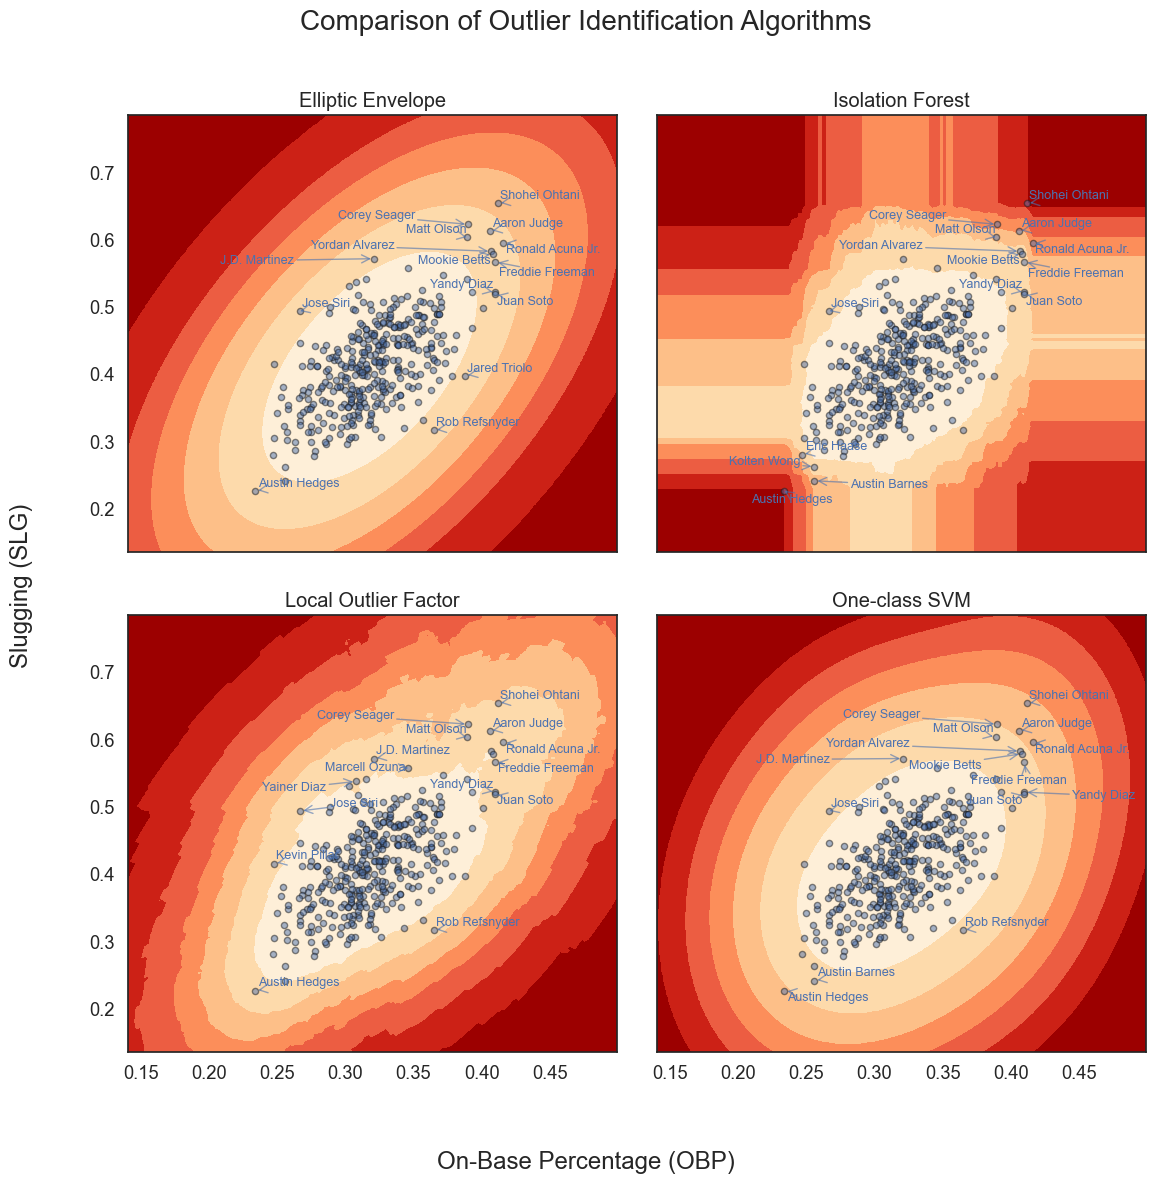

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

N_QUANTILES = 8  # Number of color breaks per chart
N_CALLOUTS = 15  # Label this many top outliers per chart

fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
fig.suptitle("Comparison of Outlier Identification Algorithms", size=20)
fig.supxlabel("On-Base Percentage (OBP)")
fig.supylabel("Slugging (SLG)")

ax_ell, ax_iso, ax_lof, ax_svm = axs.flatten()
model_abbrs = ["ell", "iso", "lof", "svm"]
models = [("Elliptic Envelope", Z_ell), ("Isolation Forest", Z_iso),
          ("Local Outlier Factor", Z_lof), ("One-class SVM", Z_svm)]

qt = QuantileTransformer(n_quantiles=N_QUANTILES)

for ax, (model_name, zz), abbr in zip([ax_ell, ax_iso, ax_lof, ax_svm], models, model_abbrs):
    ax.set_title(model_name)
    outlier_score_var_nm = f"outlier_score_{abbr}"
    qt.fit(np.sort(zz.reshape(-1, 1)))
    zz_qtl = qt.transform(zz.reshape(-1, 1)).reshape(zz.shape)
    cs = ax.contourf(xx, yy, zz_qtl, cmap=plt.cm.OrRd.reversed(), levels=np.linspace(0, 1, N_QUANTILES))
    ax.scatter(X[:, 0], X[:, 1], s=20, c="b", edgecolor="k", alpha=0.5)
    df_callouts = df.sort_values(outlier_score_var_nm).head(N_CALLOUTS)
    texts = [ax.text(row["OBP"], row["SLG"], row["Name"], c="b", size=9, alpha=1.0) for _, row in df_callouts.iterrows()]
    adjust_text(texts, df_callouts["OBP"].values, df_callouts["SLG"].values, arrowprops=dict(arrowstyle='->', color="b", alpha=0.6), ax=ax)

plt.tight_layout(pad=2)
plt.show()

for var in ["OBP", "SLG"]:
    df[f"Pctl_{var}"] = 100 * (df[var].rank() / len(df)).round(3)

model_score_vars = [f"outlier_score_{nm}" for nm in model_abbrs]
model_rank_vars = [f"Rank_{nm.upper()}" for nm in model_abbrs]
df[model_rank_vars] = df[model_score_vars].rank(axis=0, method='dense').astype(int)
df["Rank_avg"] = df[model_rank_vars].mean(axis=1)



In [88]:
print("Counting down to the greatest outlier...\n")
print(df.sort_values("Rank_avg", ascending=False)
      .tail(N_CALLOUTS)[["Name", "AB", "PA", "H", "2B", "3B", "HR", "BB", "HBP", "SO", "OBP", "Pctl_OBP", "SLG", "Pctl_SLG"] + model_rank_vars]
      .to_string(index=False))

Counting down to the greatest outlier...

            Name  AB  PA   H  2B  3B  HR  BB  HBP  SO   OBP  Pctl_OBP   SLG  Pctl_SLG  Rank_ELL  Rank_ISO  Rank_LOF  Rank_SVM
   Austin Barnes 178 200  32   5   0   2  17    2  43 0.256       2.6 0.242       0.6        19         7        25        12
   J.D. Martinez 432 479 117  27   2  33  34    2 149 0.321      52.8 0.572      98.1        15        18         5        15
      Yandy Diaz 525 600 173  35   0  22  65    8  94 0.410      99.2 0.522      95.4        13        15        13        10
       Jose Siri 338 364  75  13   2  25  20    2 130 0.267       5.5 0.494      88.4         8        14        15        13
       Juan Soto 568 708 156  32   1  35 132    2 129 0.410      99.2 0.519      95.0        12        13        11        11
    Mookie Betts 584 693 179  40   1  39  96    8 107 0.408      98.6 0.579      98.3         7        10        20         7
   Rob Refsnyder 202 243  50   9   1   1  33    5  47 0.365      90.5 0.317 

`Why use method="dense"`
while the case occur
```
ell: 0.2
iso: 0.1
lof: 0.1
svm: 0.3
```
and the rank is
```
Rank_ELL: 2
Rank_ISO: 1
Rank_LOF: 1
Rank_SVM: 3
```
but here is 
```
Rank_ELL: 3
Rank_ISO: 1
Rank_LOF: 1
Rank_SVM: 4
```

In [41]:
print(
    df.sort_values("Rank_avg",ascending=False
                  ).tail(N_CALLOUTS)[["Name","OBP","SLG"] + 
                             [f"Rank_{nm.upper()}" for nm in model_abbrs]
                            ].to_string(index=False)
)

            Name   OBP   SLG  Rank_ELL  Rank_ISO  Rank_LOF  Rank_SVM
   Austin Barnes 0.256 0.242        19         7        25        12
   J.D. Martinez 0.321 0.572        15        18         5        15
      Yandy Diaz 0.410 0.522        13        15        13        10
       Jose Siri 0.267 0.494         8        14        15        13
       Juan Soto 0.410 0.519        12        13        11        11
    Mookie Betts 0.408 0.579         7        10        20         7
   Rob Refsnyder 0.365 0.317         5        19         2        14
  Yordan Alvarez 0.407 0.583         6         9        18         6
 Freddie Freeman 0.410 0.567         9        11         9         8
      Matt Olson 0.389 0.604        11         6         7         9
   Austin Hedges 0.234 0.227        10         1         4         3
     Aaron Judge 0.406 0.613         3         5         6         4
Ronald Acuna Jr. 0.416 0.596         2         3        10         2
    Corey Seager 0.390 0.623      

Conclusion
---
Almost the same:
1. Elliptic Envelope, output has the narrower contours in the minor axis such that highlight some potential players who run contrary to the overall correlation between features. For example, Rays outfielder José Siri had high SLG (`88`th percentile), 長打率, versus low OBP (`5`th percentile), 上壘率. `Advantages`: easy to use without configuration, and it provides the robust covariance matrix; suitable for the low-dimensional data, and for nomalized data. 
2. One-class SVM, has more uniformly spaced contours, so it tends to emphasize observations along the overall direction of correlation, for instance All-Star first basemen Freddie Freeman (Dodgers), SLG+OBP: 0.99+0.97, and Yandy Diaz (Rays), SLG+OBP: 0.99+0.95.
3. LOF was the most time-consuming to implement since we created robust distance matrices for fitting and scoring and requires paramter tuning, `k`.
4. Isolation Forest tends to emphasize observations at the corners of the feature space; Austin Hedges, who played for the Pirates and Rangers in 2023 and signed with Guardians for 2024, is strong defensively but the worst batter (with at least 200 plate appearances) in both SLG and OBP; thia make him being number 1 in the method, but not Otani. However, any single one OBP or SLG should be changes the position.

Finally, Otani deserved for the $700 m for 10Y contract since three one's and one second. in the outlier dections!

In [ ]:
# Appendix

